In [8]:
import torch
from torch import nn, optim
import pandas  as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4 # la tasa de aprendizaje
NUM_CLASSES = 10 #Indica la cantidad de objetos de interés (por ejemplo un gato)
PATCH_SIZE= 4 #indica el tamaño de patch solicitado en el paper
IMAGE_SIZE = 28 #Indica el tamaño de la imagen
IN_CHANNELS = 1  #Indica la profundidad o básicamente la cantidad de canales, la parecer no será RGB (3) sino grises
NUM_HEADS = 8  #Indica el attention heads (averiguar que es eso)
DROPOUT=0.001
HIDDEN_DIM=768
ADAM_WEIGHT_DECAY=0 # Valor del optimizador, lo indica el paper
ADAM_BETAS=(0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS=4
EMBED_DIM=(PATCH_SIZE ** 2)*IN_CHANNELS #Obtiene la dimensión de un segmento de la imagen 4x4x1
NUM_PATCHES=(IMAGE_SIZE // PATCH_SIZE) ** 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
print(torch.version.cuda)
print(device)

12.6
cuda:0


In [3]:
class PatchEmbedding(nn.Module):
    """
        Esta clase es la primera etapa del ViT. Su función es:
        Dividir la imagen en parches
        Aplanarlos
        Proyectarlos a embeddings
        Añadir el token [CLS] y los embeddings posicionales
    """
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher= nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=embed_dim , kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2), # Realizamos el aplanamiento
        )
        self.cls_token= nn.Parameter(torch.rand(size=(1,1,embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1,num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        # los -1 indica que no deseamos modificar la dimensión
        cls_token= self.cls_token.expand(x.shape[0], -1, -1)
        x=self.patcher(x).permute(0,2,1)
        x=torch.cat([cls_token, x], dim=1)
        x=self.position_embedding+x
        x=self.dropout(x)
        return x
model=PatchEmbedding(embed_dim=EMBED_DIM,patch_size=PATCH_SIZE,num_patches=NUM_PATCHES,dropout=DROPOUT,in_channels=IN_CHANNELS).to(device)
#Esto simula 512 imágenes, con 1 canal (escala de grises) y tamaño 28×28.
x=torch.randn(512,1,28,28).to(device)# 50 es el numero de tokens, 16 el valor de los patches
print(model(x).shape)

torch.Size([512, 50, 16])


In [4]:
class ViT(nn.Module):
    def __init__(self, num_patches,img_size,num_classes, patch_size, embed_dim, num_encoders,num_heads, hidden_dim, dropout, activation, in_channels  ):
        super().__init__()
        self.embeddings_block=PatchEmbedding(embed_dim=embed_dim, patch_size=patch_size, num_patches=num_patches, dropout=dropout, in_channels=in_channels)
        encoder_layer=nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks=nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_encoders)
        self.mlp_head=nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:,0,:])
        return x
model=ViT(NUM_PATCHES,IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x=torch.randn(512,1,28,28).to(device)
print(model(x).shape)

D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\.venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])


# DESCARGAMOS EL DATASET DE PYTORCH

In [12]:
# Transformación: convierte la imagen a tensor y normaliza a [0, 1]
transform = transforms.ToTensor()
# Dataset de entrenamiento
train_dataset = datasets.MNIST(
    root=r'D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\vit\datasets\MNIST', train=True, download=True, transform=transform
)

# Dataset de prueba
test_dataset = datasets.MNIST(
    root=r'D:\programacion\proyectos\utec\IA\modulo_2_redes_convolucionales_y_generativas\vit\datasets\MNIST', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ENTRENAMIENTO

In [14]:
import timeit # mide el tiempo de entrenamiento
from tqdm import tqdm #muestra una barra de progreso para mostrar visualmente el progeso del entrenamiento
import torch.nn as nn #contiene los módulos de pytorch

criterion = nn.CrossEntropyLoss() #función de pérdida compara los logits del modelo con los labels verdaderos
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY) #Uso del optimizador ADAM

start = timeit.default_timer()
#Ciclo principal de épocas
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    # --- Entrenamiento ---
    model.train()#modo de entrenamiento
    train_labels = []
    train_preds = []
    train_running_loss = 0

    for idx, (img, label) in enumerate(tqdm(train_loader, position=0, leave=True)): # loop por batch de entrenamiento
        img = img.float().to(device) # convierte la imagen a tipo float                    # [B, 1, 28, 28]
        label = label.long().to(device)# convierte el label a un int64 usado por CrossEntropyLoss # [B]

        y_pred = model(img) # salida del modelo                              # [B, num_classes]
        y_pred_label = torch.argmax(y_pred, dim=1) #predicción final (clase con mayor probabilidad)  # [B]

        #Se guardan etiquetas reales y prdeichas para calcular el accuracy más adelante
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        # Calcula la pérdida entre la predicción y ground truth
        loss = criterion(y_pred, label)
        optimizer.zero_grad() #limpia gradiente anteriores
        loss.backward() # calcula nuevos gradientes
        optimizer.step() #actualiza pesos

        train_running_loss += loss.item() #acumula la perdida del batch

    train_loss = train_running_loss / (idx + 1) #Promedio de la pérdida total por cantidad de batches

    # --- Validación ---
    model.eval() # desactiva dropout y batchnorm
    val_labels = []
    val_preds = []
    val_running_loss = 0

    with torch.no_grad(): # ss desactiva el cálculo de gradiente (ahorra memoria y es más rápido)
        for idx, (img, label) in enumerate(tqdm(test_loader, position=0, leave=True)): # loop de validación por batches
            img = img.float().to(device)
            label = label.long().to(device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    #forward, predicción, cálculo de pérdida, guardar resultados
    val_loss = val_running_loss / (idx + 1)

    # --- Estadísticas ---
    print("-" * 30)
    print(f"Train Loss Epoch {epoch + 1}: {train_loss:.4f}")
    print(f"Valid Loss Epoch {epoch + 1}: {val_loss:.4f}")
    print(f"Train Accuracy Epoch {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy Epoch {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop - start:.2f}s")
# Guardar los pesos del modelo entrenado
torch.save(model.state_dict(), "vit_mnist.pth")
print("Modelo guardado exitosamente como 'vit_mnist.pth'")


100%|██████████| 20/20 [00:01<00:00, 14.79it/s]


------------------------------
Train Loss Epoch 1: 1.1157
Valid Loss Epoch 1: 0.9761
Train Accuracy Epoch 1: 0.7260


  2%|▎         | 1/40 [00:17<11:22, 17.49s/it]

Valid Accuracy Epoch 1: 0.7841
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


------------------------------
Train Loss Epoch 2: 0.9754
Valid Loss Epoch 2: 0.8661
Train Accuracy Epoch 2: 0.7722


  5%|▌         | 2/40 [00:34<10:56, 17.27s/it]

Valid Accuracy Epoch 2: 0.8137
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.67it/s]


------------------------------
Train Loss Epoch 3: 0.8693
Valid Loss Epoch 3: 0.7957
Train Accuracy Epoch 3: 0.8024


  8%|▊         | 3/40 [00:52<10:44, 17.41s/it]

Valid Accuracy Epoch 3: 0.8308
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


------------------------------
Train Loss Epoch 4: 0.7844
Valid Loss Epoch 4: 0.7152
Train Accuracy Epoch 4: 0.8227


 10%|█         | 4/40 [01:09<10:26, 17.40s/it]

Valid Accuracy Epoch 4: 0.8417
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.49it/s]


------------------------------
Train Loss Epoch 5: 0.7030
Valid Loss Epoch 5: 0.6321
Train Accuracy Epoch 5: 0.8402


 12%|█▎        | 5/40 [01:26<10:06, 17.34s/it]

Valid Accuracy Epoch 5: 0.8669
------------------------------


100%|██████████| 20/20 [00:01<00:00, 12.77it/s]


------------------------------
Train Loss Epoch 6: 0.6422
Valid Loss Epoch 6: 0.5485


 15%|█▌        | 6/40 [01:44<09:56, 17.56s/it]

Train Accuracy Epoch 6: 0.8525
Valid Accuracy Epoch 6: 0.8817
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.38it/s]


------------------------------
Train Loss Epoch 7: 0.5775
Valid Loss Epoch 7: 0.5206
Train Accuracy Epoch 7: 0.8664


 18%|█▊        | 7/40 [02:02<09:41, 17.61s/it]

Valid Accuracy Epoch 7: 0.8888
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.05it/s]


------------------------------
Train Loss Epoch 8: 0.5352
Valid Loss Epoch 8: 0.4777
Train Accuracy Epoch 8: 0.8749


 20%|██        | 8/40 [02:20<09:25, 17.68s/it]

Valid Accuracy Epoch 8: 0.8932
------------------------------


100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


------------------------------
Train Loss Epoch 9: 0.4929
Valid Loss Epoch 9: 0.4510


 22%|██▎       | 9/40 [02:38<09:10, 17.74s/it]

Train Accuracy Epoch 9: 0.8831
Valid Accuracy Epoch 9: 0.8939
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.36it/s]


------------------------------
Train Loss Epoch 10: 0.4541
Valid Loss Epoch 10: 0.3924


 25%|██▌       | 10/40 [02:55<08:51, 17.71s/it]

Train Accuracy Epoch 10: 0.8900
Valid Accuracy Epoch 10: 0.9124
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.71it/s]


------------------------------
Train Loss Epoch 11: 0.4237
Valid Loss Epoch 11: 0.4041
Train Accuracy Epoch 11: 0.8958


 28%|██▊       | 11/40 [03:13<08:32, 17.67s/it]

Valid Accuracy Epoch 11: 0.8980
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.54it/s]


------------------------------
Train Loss Epoch 12: 0.3994
Valid Loss Epoch 12: 0.3642
Train Accuracy Epoch 12: 0.9003


 30%|███       | 12/40 [03:30<08:11, 17.54s/it]

Valid Accuracy Epoch 12: 0.9109
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


------------------------------
Train Loss Epoch 13: 0.3791
Valid Loss Epoch 13: 0.3729


 32%|███▎      | 13/40 [03:48<07:52, 17.48s/it]

Train Accuracy Epoch 13: 0.9044
Valid Accuracy Epoch 13: 0.9068
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.24it/s]


------------------------------
Train Loss Epoch 14: 0.3573
Valid Loss Epoch 14: 0.3258
Train Accuracy Epoch 14: 0.9074


 35%|███▌      | 14/40 [04:05<07:34, 17.49s/it]

Valid Accuracy Epoch 14: 0.9226
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.48it/s]


------------------------------
Train Loss Epoch 15: 0.3373
Valid Loss Epoch 15: 0.3066
Train Accuracy Epoch 15: 0.9129


 38%|███▊      | 15/40 [04:23<07:17, 17.52s/it]

Valid Accuracy Epoch 15: 0.9246
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.39it/s]


------------------------------
Train Loss Epoch 16: 0.3203
Valid Loss Epoch 16: 0.2939
Train Accuracy Epoch 16: 0.9154


 40%|████      | 16/40 [04:40<07:00, 17.54s/it]

Valid Accuracy Epoch 16: 0.9270
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.44it/s]


------------------------------
Train Loss Epoch 17: 0.3078
Valid Loss Epoch 17: 0.2725
Train Accuracy Epoch 17: 0.9186


 42%|████▎     | 17/40 [04:59<06:48, 17.77s/it]

Valid Accuracy Epoch 17: 0.9293
------------------------------


100%|██████████| 20/20 [00:01<00:00, 12.92it/s]


------------------------------
Train Loss Epoch 18: 0.2881
Valid Loss Epoch 18: 0.2834
Train Accuracy Epoch 18: 0.9223


 45%|████▌     | 18/40 [05:17<06:36, 18.02s/it]

Valid Accuracy Epoch 18: 0.9282
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


------------------------------
Train Loss Epoch 19: 0.2847
Valid Loss Epoch 19: 0.2544


 48%|████▊     | 19/40 [05:35<06:16, 17.93s/it]

Train Accuracy Epoch 19: 0.9234
Valid Accuracy Epoch 19: 0.9359
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.49it/s]


------------------------------
Train Loss Epoch 20: 0.2706
Valid Loss Epoch 20: 0.2594
Train Accuracy Epoch 20: 0.9253


 50%|█████     | 20/40 [05:52<05:56, 17.82s/it]

Valid Accuracy Epoch 20: 0.9333
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.52it/s]


------------------------------
Train Loss Epoch 21: 0.2631
Valid Loss Epoch 21: 0.2439
Train Accuracy Epoch 21: 0.9274


 52%|█████▎    | 21/40 [06:10<05:36, 17.72s/it]

Valid Accuracy Epoch 21: 0.9364
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.36it/s]


------------------------------
Train Loss Epoch 22: 0.2602
Valid Loss Epoch 22: 0.2316
Train Accuracy Epoch 22: 0.9281


 55%|█████▌    | 22/40 [06:28<05:22, 17.93s/it]

Valid Accuracy Epoch 22: 0.9401
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.37it/s]


------------------------------
Train Loss Epoch 23: 0.2425
Valid Loss Epoch 23: 0.2366
Train Accuracy Epoch 23: 0.9330


 57%|█████▊    | 23/40 [06:46<05:04, 17.90s/it]

Valid Accuracy Epoch 23: 0.9362
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.96it/s]


------------------------------
Train Loss Epoch 24: 0.2350
Valid Loss Epoch 24: 0.2182
Train Accuracy Epoch 24: 0.9347


 60%|██████    | 24/40 [07:04<04:45, 17.81s/it]

Valid Accuracy Epoch 24: 0.9420
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.94it/s]


------------------------------
Train Loss Epoch 25: 0.2317
Valid Loss Epoch 25: 0.2343
Train Accuracy Epoch 25: 0.9351


 62%|██████▎   | 25/40 [07:21<04:26, 17.79s/it]

Valid Accuracy Epoch 25: 0.9369
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.30it/s]


------------------------------
Train Loss Epoch 26: 0.2323
Valid Loss Epoch 26: 0.2057
Train Accuracy Epoch 26: 0.9337


 65%|██████▌   | 26/40 [07:39<04:08, 17.78s/it]

Valid Accuracy Epoch 26: 0.9448
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.37it/s]


------------------------------
Train Loss Epoch 27: 0.2190
Valid Loss Epoch 27: 0.2116


 68%|██████▊   | 27/40 [07:57<03:51, 17.82s/it]

Train Accuracy Epoch 27: 0.9375
Valid Accuracy Epoch 27: 0.9426
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.41it/s]


------------------------------
Train Loss Epoch 28: 0.2129
Valid Loss Epoch 28: 0.2144


 70%|███████   | 28/40 [08:16<03:36, 18.04s/it]

Train Accuracy Epoch 28: 0.9395
Valid Accuracy Epoch 28: 0.9393
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.42it/s]


------------------------------
Train Loss Epoch 29: 0.2161
Valid Loss Epoch 29: 0.1905


 72%|███████▎  | 29/40 [08:34<03:20, 18.21s/it]

Train Accuracy Epoch 29: 0.9384
Valid Accuracy Epoch 29: 0.9480
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.09it/s]


------------------------------
Train Loss Epoch 30: 0.2058
Valid Loss Epoch 30: 0.1911
Train Accuracy Epoch 30: 0.9405


 75%|███████▌  | 30/40 [08:52<03:01, 18.19s/it]

Valid Accuracy Epoch 30: 0.9504
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.63it/s]


------------------------------
Train Loss Epoch 31: 0.1979
Valid Loss Epoch 31: 0.1999
Train Accuracy Epoch 31: 0.9427


 78%|███████▊  | 31/40 [09:11<02:43, 18.15s/it]

Valid Accuracy Epoch 31: 0.9441
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.26it/s]


------------------------------
Train Loss Epoch 32: 0.1905
Valid Loss Epoch 32: 0.1830
Train Accuracy Epoch 32: 0.9444


 80%|████████  | 32/40 [09:28<02:24, 18.08s/it]

Valid Accuracy Epoch 32: 0.9498
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.01it/s]


------------------------------
Train Loss Epoch 33: 0.1895
Valid Loss Epoch 33: 0.1751
Train Accuracy Epoch 33: 0.9444


 82%|████████▎ | 33/40 [09:46<02:05, 17.99s/it]

Valid Accuracy Epoch 33: 0.9526
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.86it/s]


------------------------------
Train Loss Epoch 34: 0.1892
Valid Loss Epoch 34: 0.1808
Train Accuracy Epoch 34: 0.9443


 85%|████████▌ | 34/40 [10:04<01:47, 17.97s/it]

Valid Accuracy Epoch 34: 0.9485
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.26it/s]


------------------------------
Train Loss Epoch 35: 0.1815
Valid Loss Epoch 35: 0.1899
Train Accuracy Epoch 35: 0.9468


 88%|████████▊ | 35/40 [10:22<01:29, 17.94s/it]

Valid Accuracy Epoch 35: 0.9448
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.30it/s]


------------------------------
Train Loss Epoch 36: 0.1861
Valid Loss Epoch 36: 0.1770


 90%|█████████ | 36/40 [10:40<01:11, 17.96s/it]

Train Accuracy Epoch 36: 0.9446
Valid Accuracy Epoch 36: 0.9487
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.28it/s]


------------------------------
Train Loss Epoch 37: 0.1817
Valid Loss Epoch 37: 0.1700


 92%|█████████▎| 37/40 [10:58<00:54, 18.02s/it]

Train Accuracy Epoch 37: 0.9465
Valid Accuracy Epoch 37: 0.9513
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.37it/s]


------------------------------
Train Loss Epoch 38: 0.1701
Valid Loss Epoch 38: 0.1627


 95%|█████████▌| 38/40 [11:16<00:35, 17.98s/it]

Train Accuracy Epoch 38: 0.9495
Valid Accuracy Epoch 38: 0.9549
------------------------------


100%|██████████| 20/20 [00:01<00:00, 14.13it/s]


------------------------------
Train Loss Epoch 39: 0.1667
Valid Loss Epoch 39: 0.1562
Train Accuracy Epoch 39: 0.9510


 98%|█████████▊| 39/40 [11:35<00:18, 18.13s/it]

Valid Accuracy Epoch 39: 0.9565
------------------------------


100%|██████████| 20/20 [00:01<00:00, 13.13it/s]


------------------------------
Train Loss Epoch 40: 0.1628
Valid Loss Epoch 40: 0.1612
Train Accuracy Epoch 40: 0.9513


100%|██████████| 40/40 [11:53<00:00, 17.83s/it]

Valid Accuracy Epoch 40: 0.9546
------------------------------
Training Time: 713.25s
Modelo guardado exitosamente como 'vit_mnist.pth'


# VALIDAMOS RESULTADOS

In [15]:
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.cuda.empty_cache()

labels = []
imgs = []

model.eval()
with torch.no_grad():
    for idx, (img, _) in enumerate(tqdm(test_loader, position=0, leave=True)):
        img = img.to(device)

        outputs = model(img)  # [B, 10]
        preds = torch.argmax(outputs, dim=1)

        imgs.extend(img.detach().cpu())
        labels.extend(preds.cpu().tolist())


100%|██████████| 20/20 [00:01<00:00, 13.50it/s]


<Figure size 800x600 with 0 Axes>

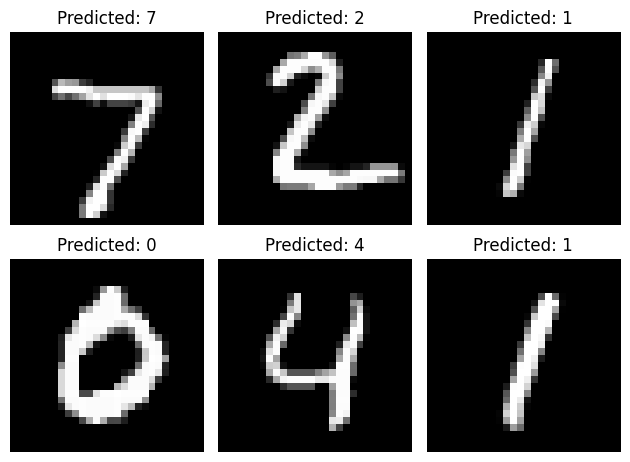

In [16]:
plt.figure(figsize=(8, 6))
f, axarr = plt.subplots(2, 3)

counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted: {labels[counter]}")
        axarr[i][j].axis('off')
        counter += 1
plt.tight_layout()
plt.show()
